In [ ]:
#|default_exp fff

In [ ]:
#|hide
import nbdev
import math
import torch.optim as optim
from torch import tensor
import torchvision.transforms as T
from torchvision.datasets import MNIST
from fastai.vision.all import *
from fastai.callback.wandb import *

import FastFF.imports.fff as fff
from FastFF.activations import *
from FastFF.performance import *

In [ ]:
#|export
import torch
import torch.nn as nn, torch.nn.functional as F
from fastcore.all import *

## Fast Feed-Forward

> Reimplementation of FFF

In [ ]:
#|export
class FFF(nn.Module):
    def __init__(self, in_dim, out_dim, depth, act=nn.ReLU, p=0., hidden_dim = None, save_probs=True):
        super().__init__()
        store_attr()
        if p != 0: self.dropout = nn.Dropout(p)
        self.n_leaves = 2**depth
        self.nodes = nn.Linear(in_dim, self.n_leaves-1) if depth!=0 else nn.Identity()
        self.leaves = nn.Linear(in_dim, ifnone(hidden_dim, out_dim)*self.n_leaves)
        if hidden_dim: self.leaves_out = nn.ModuleList(nn.Linear(hidden_dim, out_dim) for _ in range(self.n_leaves))
        self.act = act() if act else nn.Identity()
 
    def forward(self, x): return self.train_forward(x) if self.training else self.eval_forward(x)

    def train_forward(self, x):
        bs = x.shape[0]
        logits = self.nodes(x) # (bs, n_leaves-1)
        if hasattr(self,'dropout'): logits = self.dropout(logits)
        
        logprobs = F.logsigmoid(torch.stack([-logits, logits],dim=2)) # (bs, n_leaves-1, 2)
        probs = torch.zeros([bs,self.n_leaves], device=x.device)     # (bs, n_leaves)
        for d in range(self.depth):
            mask = logprobs[:, 2**d-1 : 2**(d+1)-1].view(bs,-1, 1)        # (bs, 2*2**d, 1)
            probs = probs.view(bs, 2**(d+1), -1) + mask         # (bs, 2**(d+1), n_leaves//2**(d+1) )
        probs = torch.exp(probs).view(bs, -1, 1)
        
        # save distribution for visuals
        if self.save_probs: self.probs = probs.detach()
        
        x = self.act(self.leaves(x)).view(bs,self.n_leaves, -1)               # (bs, n_leaves, out_dim/hidden_dim)
        if self.hidden_dim: x =  self.act(torch.stack([self.leaves_out[i](x[:,i,:]) for i in range(self.n_leaves)], dim=1)) # (bs, n_leaves, out_dim)
        return torch.bmm(x.transpose(1,2), probs).squeeze(-1)
    
    def eval_forward(self, x):
        bs = x.shape[0]
        logits = self.nodes(x)
        choices = logits>0 # (bs, n_leaves-1)
        probs = torch.zeros((bs,1), dtype=torch.long, device=x.device)
        for _ in range(self.depth):
            probs = 2 * probs + 1 + choices.gather(1,probs) # (bs, 1)
        probs = probs.squeeze(-1) - self.n_leaves + 1
        
        # save distribution for visuals
        if self.save_probs: self.probs = probs.detach()
        
        w, b = self.leaves.weight.view(self.n_leaves, -1, self.in_dim), self.leaves.bias.view(self.n_leaves, -1)
        w = torch.index_select(w, 0, probs.squeeze()) # (bs, in_dim, out_dim/hidden_dim)
        b = torch.index_select(b, 0, probs.squeeze()) # (bs, out_dim/hidden_dim)
        
        x = self.act(torch.bmm(w, x[...,None]).squeeze(-1) + b) # (bs, out_dim/hidden_dim)
        if self.hidden_dim: x =  self.act(torch.stack([self.leaves_out[b](x[i]) for i,b in enumerate(probs)], dim=0))
        return x

## Model performance comparison

In [ ]:
d,h = 3, 128
x = to_device(torch.randn(2,28*28))

In [ ]:
model = FFF(28*28, 10, d, hidden_dim=h).to(x.device).train()
with torch.no_grad():
    %timeit -n 100 model(x);

1.09 ms ± 632 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
model = fff.FFF(28*28, h, 10,  d).to(x.device).train()
with torch.no_grad():
    %timeit -n 100 model(x);

3.14 ms ± 444 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Training

In [ ]:
#|hide
#|eval: false
h = 32
d = 3
bs = 256


model = FFF(28*28, 10, d, act=nn.ReLU, p=0., hidden_dim=h)
leaves = model.leaves_out
cbs = [ProbsDistrCB(), GetGradCB([model.nodes, model.leaves, *leaves])]
Learner(get_mnist_dls(bs), model, loss_func=F.cross_entropy, metrics=accuracy, cbs=cbs).fit_one_cycle(10, lr_max=7e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.269327,0.445445,0.885000,00:16
1,0.187561,0.327196,0.918100,00:20
2,0.159384,0.343243,0.906200,00:17
3,0.126082,0.271401,0.931700,00:13
4,0.107962,0.246315,0.937000,00:13
5,0.073111,0.196382,0.948600,00:18
6,0.042389,0.175647,0.958900,00:14
7,0.026250,0.157403,0.963300,00:14
8,0.012846,0.150221,0.965300,00:14
9,0.008967,0.142253,0.967700,00:14


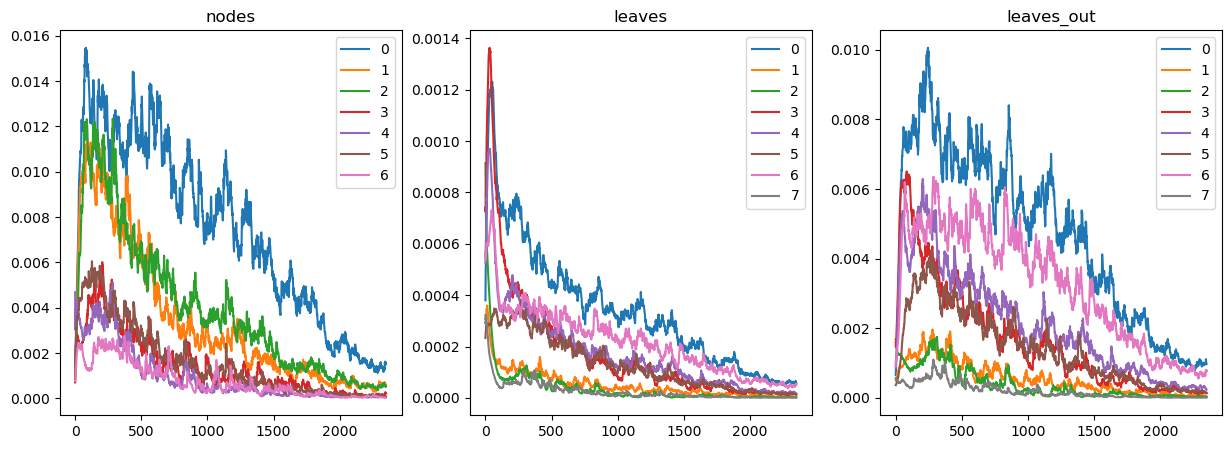

In [ ]:
axes = subplots(figsize=(15,5), ncols=3)[1]
for i, k in enumerate(['nodes','leaves','leaves_out']): axes[i].title.set_text(k)
cbs[1].show(model.nodes, lambda x: x.abs().mean(-1), ax=axes[0])
cbs[1].show(model.leaves, lambda x: x.abs().mean(-1).view(len(x), model.n_leaves, -1).mean(-1), ax=axes[1])
for i, l in enumerate(leaves): cbs[1].show(l, ax=axes[2], label = i)

In [ ]:
ax = subplots(figsize=(8,4))[1][0]
cbs[0].show(-1, ax=ax)

In [ ]:
#|hide
#|eval: false
h = 32
d = 3
bs = 256


modelf = FFF(28*28, 10, d, act=nn.ReLU, p=0., hidden_dim=h)
leaves = modelf.leaves_out
cbbs = [ProbsDistrCB(), GetGradCB([modelf.nodes, modelf.leaves, *leaves])]
Learner(get_mnist_dls(bs), modelf, loss_func=F.cross_entropy, metrics=accuracy, cbs=cbbs).fit_one_cycle(10, lr_max=7e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.312533,0.194125,0.937300,00:11
1,0.164719,0.148286,0.953900,00:09
2,0.136067,0.136047,0.956200,00:12
3,0.119031,0.117129,0.966500,00:08
4,0.104981,0.119000,0.965100,00:09
5,0.086151,0.115862,0.967500,00:11
6,0.066813,0.114081,0.972100,00:10
7,0.051902,0.108751,0.971600,00:10
8,0.034955,0.088329,0.977900,00:10
9,0.022769,0.082397,0.978500,00:09


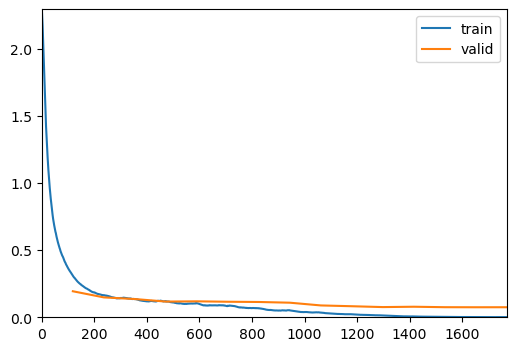

In [ ]:
#|hide
#|eval: false
model = FFF(28*28, 10, d, act=nn.GELU, p=0., hidden_dim=h, bn=True)
cbs = [ProbsDistrCB(), GetGradCB(['nodes.weight', 'leaves.weight']), ShowGraphCallback(), ActivationStats(True, every=4)]
learn = Learner(dls, model, loss_func=F.cross_entropy, metrics=accuracy, opt_func = Adam, cbs=cbs)
learn.fit_one_cycle(15, lr_max=2e-2);

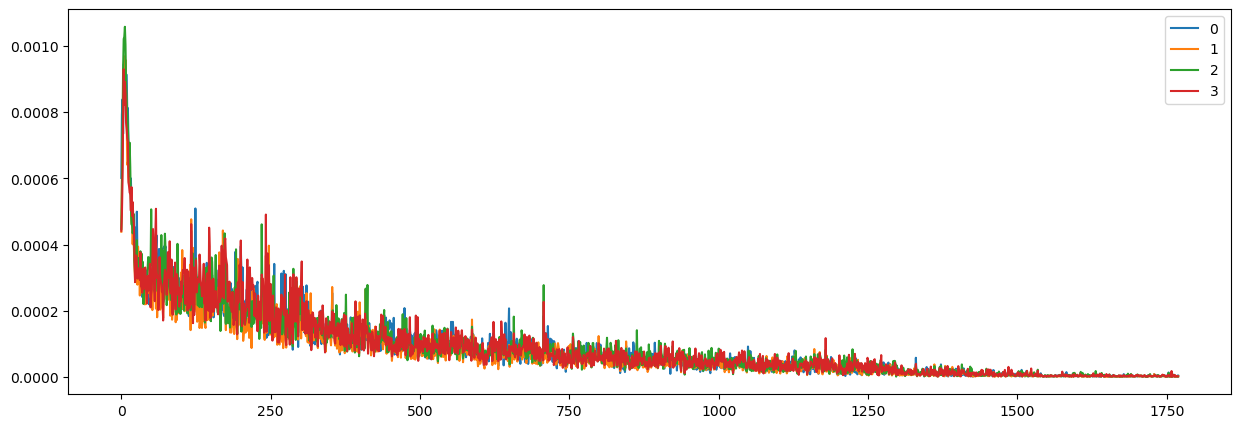

In [ ]:
ax = subplots(figsize=(15,5))[1][0]
cbs[1].show('leaves.weight', ax=ax, normalize=lambda x: x.view(-1, model.n_leaves, h, model.in_dim).abs().mean((2,3)))

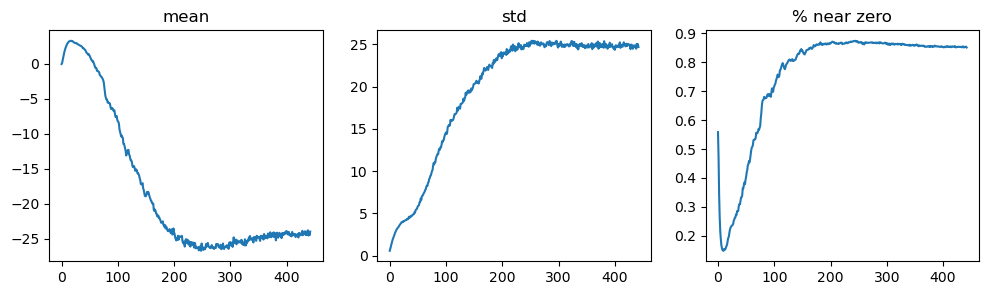

In [ ]:
cbs[-1].plot_layer_stats(1)